In [1]:
import random
random.seed(42)
import numpy as np
np.random.seed(seed=42)

import pandas as pd

#df = pd.read_pickle('/anomalyvol/figures2/GNN_AE_EdgeConv_Finished/rnd/df.pkl')
df = pd.read_pickle('/anomalyvol/figures2/GNN_AE_EdgeConv_Finished/bb1/df.pkl')
#df = pd.read_pickle('/anomalyvol/figures2/GNN_AE_EdgeConv_Finished/bb2/df.pkl')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import mplhep as hep
plt.style.use(hep.style.CMS)

signal_mjj = np.array([1, 3, 6, 10, 16, 23, 31, 40, 50, 61, 74, 88, 103, 119, 137, 156, 
              176, 197, 220, 244, 270, 296, 325, 354, 386, 419, 453, 489, 526, 
              565, 606, 649, 693, 740, 788, 838, 890, 944, 1000, 1058, 1118, 
              1181, 1246, 1313, 1383, 1455, 1530, 1607, 1687, 1770, 1856, 
              1945, 2037, 2132, 2231, 2332, 2438, 2546, 2659, 2775, 2895, 
              3019, 3147, 3279, 3416, 3558, 3704, 3854, 4010, 4171, 4337, 
              4509, 4686, 4869, 5058, 5253, 5455, 5663, 5877, 6099, 6328, 
              6564, 6808, 7060, 7320, 7589, 7866, 8152, 8447, 8752, 9067, 
              9391, 9726, 10072, 10430, 10798, 11179, 11571, 11977, 12395, 
              12827, 13272, 13732, 14000])

bins = signal_mjj[(signal_mjj >= 2659) * (signal_mjj <= 6099)]

xmin = bins[0]
xmax = bins[-1]

def fit_function(x, p0, p1, p2, p3, p4):
    xnorm = (x-xmin)/(xmax-xmin)
    return p0 + p1*xnorm + p2*xnorm**2 + p3*xnorm**3 + p4*xnorm**4

(10097,)
(989604,)


[]

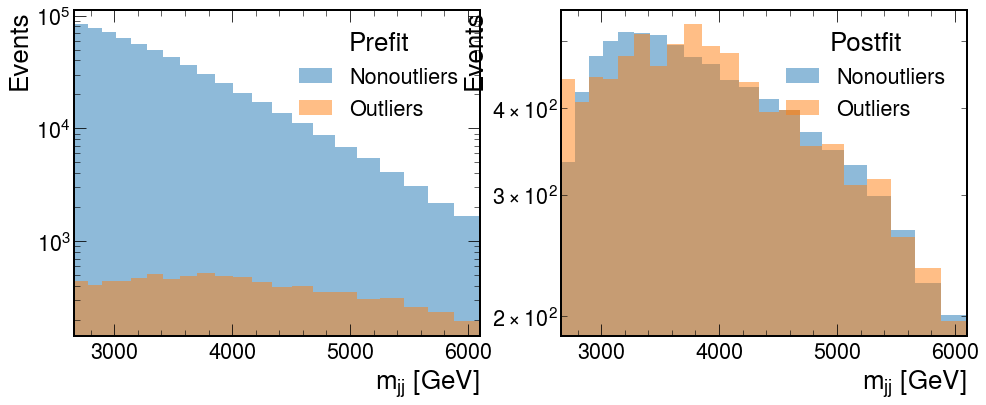

In [17]:
all_losses = np.concatenate((df['loss1'],df['loss2']))

thresh = np.quantile(all_losses, 0.9) 
min_loss = np.minimum(df['loss1'],df['loss2'])


dijet_mass = df['dijet_mass']
outlier = (min_loss > thresh)

pass_mass = dijet_mass[outlier]
fail_mass = dijet_mass[~outlier]
print(pass_mass.shape)
print(fail_mass.shape)

pass_hist, _ = np.histogram(pass_mass, bins=bins)
fail_hist, _ = np.histogram(fail_mass, bins=bins)


binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=pass_hist/fail_hist, 
                       p0=[1]*5)

f, axs = plt.subplots(1,2, figsize=(16, 6))

axs[0].hist(fail_mass,bins=bins,alpha=0.5, label='Nonoutliers')
axs[0].hist(pass_mass,bins=bins,alpha=0.5, label='Outliers')
axs[0].set_xlim(xmin, xmax)
#axs[0].set_ylim(1, 1e4)
axs[0].set_xlabel(r'$m_{jj}$ [GeV]')
axs[0].set_ylabel(r'Events')
axs[0].legend(title='Prefit')
axs[0].semilogy()

axs[1].hist(fail_mass,bins=bins,weights=fit_function(fail_mass, *popt),alpha=0.5, label='Nonoutliers')
axs[1].hist(pass_mass,bins=bins,alpha=0.5, label='Outliers')
axs[1].set_xlabel(r'$m_{jj}$ [GeV]')
axs[1].set_ylabel(r'Events')
axs[1].set_xlim(xmin, xmax)
#axs[1].set_ylim(1,1e4)
axs[1].legend(title='Postfit')
axs[1].semilogy()

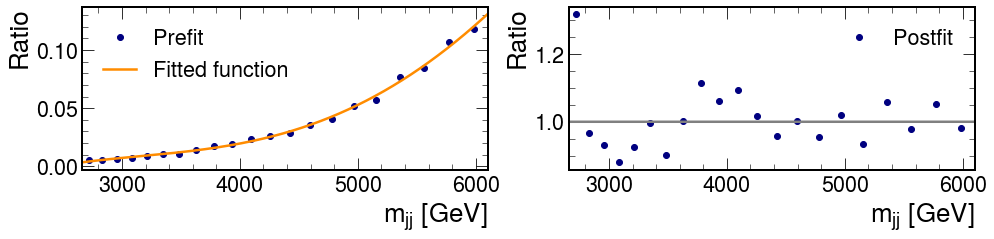

In [18]:
# Plot the histogram and the fitted function.

# Generate enough x values to make the curves look smooth.
xspace = np.linspace(xmin, xmax, 100000)

fail_hist_weighted, _ = np.histogram(fail_mass, bins=bins, weights=fit_function(fail_mass, *popt))

f, axs = plt.subplots(1,2, figsize=(16, 3))
axs[0].plot(binscenters, pass_hist/fail_hist, color='navy', label=r'Prefit', marker='o',linestyle='')
axs[0].plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
axs[0].set_xlabel(r'$m_{jj}$ [GeV]')
axs[0].set_xlim(xmin, xmax)
#axs[0].set_ylim(0, 2)
axs[0].set_ylabel(r'Ratio')
axs[0].legend()
axs[1].plot(binscenters, pass_hist/fail_hist_weighted, color='navy', label=r'Postfit', marker='o',linestyle='')
axs[1].plot(xspace, np.ones_like(xspace), color='gray', linewidth=2.5)
axs[1].set_xlabel(r'$m_{jj}$ [GeV]')
axs[1].set_ylabel(r'Ratio')
axs[1].set_xlim(xmin, xmax)
#axs[1].set_ylim(0, 2)
axs[1].legend(loc='upper right')

Generating histograms
4 values of width will be tested
SCAN
Global p-value : 0.0187  (187 / 10000)
Significance = 2.08137

BUMP POSITION
   min : 3704.000
   max : 4171.000
   mean : 3937.500
   width : 467.000
   number of signal events : 124.23820011378439
   global p-value : 0.01870
   significance = 2.08137



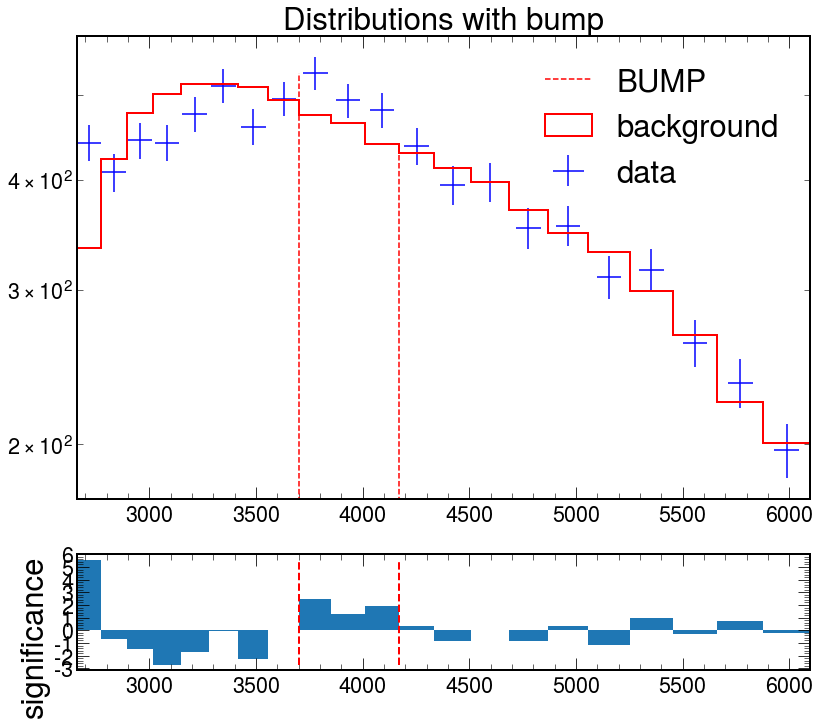

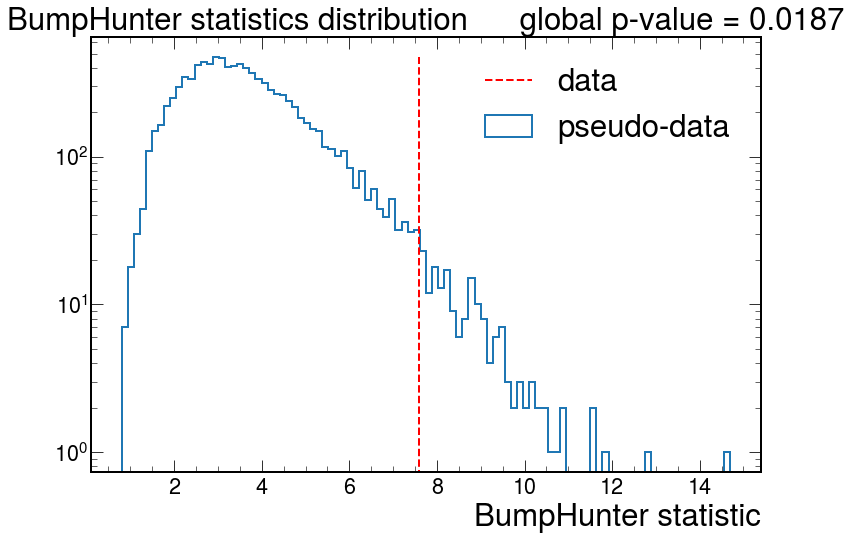

In [5]:
import pyBumpHunter as BH
import sys
import mplhep 
bh = BH.BumpHunter(rang=[bins[0],bins[-1]],
                        bins=bins,
                        weights=fit_function(fail_mass, *popt),
                        width_min=2,
                        width_max=5, Npe=10000)
bh.BumpScan(pass_mass, fail_mass)
bh.PrintBumpTrue(pass_mass, fail_mass)
bh.PlotBump(data=pass_mass, bkg=fail_mass)
bh.PlotBHstat(show_Pval=True)